In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook
import random

from argparse import Namespace
import os
import collections
from collections import Counter

import string

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# @@@@@ 0. Settings

In [2]:
##### 'TRAIN' a new model or 'LOAD' an existing model 
get_model = 'TRAIN'

In [3]:
args = Namespace(
    # Training or loading
    get_model   = get_model,
    
    # Data and Path information
    input_path  = os.getcwd(),
    output_path = os.getcwd()+'/OUTPUT/',
    save_model_name = 'frankenstein_model.pth',
    # Training hyperparameters
    embedding_size  = 50,
    learning_rate   = 0.0001,
    batch_size      = 32,
    device          = 'cpu',
    num_epochs      = 100,
    early_stopping_criteria = 5
)

# @@@@@ 1. Data Preparation
## The data preparation part is to perform a text-to-vectorized-minibatch pipeline: converting text inputs to vectorized minibatches.
- ### Step 1: Creating a Vocabulary - mapping each token (words in the context of contexts) in the Frankenstein data to a numerical version of itself.
- ### Step 2: Vectorization - going from a text dataset to a vector. The Vectorizer turns different contexts to vectors of integers with the same length.
- ### Step 3: Group the vectorized data points into batches.

## 1.1 - Read Data
### [Creation of the CBOW data "frankenstein_with_splits.csv"](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Frankenstein/frankenstein_CBOW_data.ipynb)

### **Train partition**: a dataset to derive the model parameters
### **Valid partition**: a dataset for selecting among hyperparameters and making modeling decisions
### **Test partition**: a dataset for final evaluation and reporting

In [4]:
df_all = pd.read_csv('frankenstein_with_splits.csv')
df_all.sample(5)

,context,target,split
42967,to express that bestowed on him,she,train
32342,"and sometimes of , in your",revenge,train
7015,my father entered chamber .,the,train
76216,"and i must , in a",tell,val
46384,was left alone unacquainted with the,",",train


,context,target,split
42967,to express that bestowed on him,she,train
32342,"and sometimes of , in your",revenge,train
7015,my father entered chamber .,the,train
76216,"and i must , in a",tell,val
46384,was left alone unacquainted with the,",",train


## 1.2 - The Vocabulary class
### [A walkthrough of codes](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Frankenstein/class_Vocabulary.ipynb)
### - Creating a mapping between the tokens and integers, in terms of dictionaries. To make this mapping reversible, create two dictionaries, one is from-token-to-index, one is from-index-to-token. Then encapsulate this mapping (bijection) into a Vocabulary class.
### - By using the UNK token, we can handle tokens at test time that were never seen in training.
### - There is one additional optional step for creating the vocabulary - couting the tokens appeared in the "context" and "target" columns , and ONLY add frequent tokens that apprear more than a pre-specified number to the Vocabulary, while treat infrequent tokens as UNK.  See an example with cutoff = 25 [here](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Yelp_Reviews/yelp_perceptron.ipynb).. 
### - Expected behaviors:
#### (1) add_token(): to add new tokens to the Vocabulary
#### (2) lookup_token(): to retrieve the index for a token
#### (3) lookup_index(): to retrieve the token corresponding to a specific index.
### - The Vocabulary objects will be used in the Vectorization step (discussed next). 


In [5]:
class Vocabulary(object):
   
    def __init__(self, token_to_idx=None, 
                 mask_token="<MASK>", add_unk=True, 
                 unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            mask_token (str): the MASK token to add into the Vocabulary; indicates
                a position that will not be used in updating the model's parameters
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk   = add_unk
        self._unk_token = unk_token    
        self._mask_token = mask_token
        
        ### the mask_token, i.e, "<MASK>" is the first added token
        self.mask_index = self.add_token(self._mask_token)
        
        self.unk_index  = -999
        ### the unk_token, i.e, "<UNK>" is the second added token if add_unk=True
        ### self.unk_index is changed from -999 to 1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            ### add a new element to _token_to_idx
            self._token_to_idx[token] = index
            ### add a new element to _idx_to_token
            self._idx_to_token[index] = token
        return index
   
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            ### .get(): return self.unk_index if the key "token" does not exist. 
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]
    
    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]
    
    def __len__(self):
        return len(self._token_to_idx)

## 1.3 - Vectorization
### [A walkthrough of codes](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Frankenstein/class_Vectorizer.ipynb)
### - The class method **from_dataframe()** is used to instantiate a CBOWVectorizer object from a dataframe.
### - The cbow_vocab will be used as the reference for vector representation, which is a vector of integers representing the indices of the context.
### - The class method **vectorize()** is the core functionality of the Vectorizer. It takes as an argument a string representing a row of cbow_df (joined comment and target) and returns a vectorized representation (a vector) of the string. The length of the vectors is equal to the number of tokens in the longest contexts in the data. The vectorized representation of texts with different lengths should have the same length.       

In [6]:
class CBOWVectorizer(object):
    
    def __init__(self, cbow_vocab):
        """
        Args:
            cbow_vocab (Vocabulary): maps words to integers
        """
        self.cbow_vocab = cbow_vocab
         
    @classmethod
    def from_dataframe(cls, cbow_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            cbow_df (pandas.DataFrame): the target dataset
        Returns:
            an instance of the CBOWVectorizer
        """
        cbow_vocab = Vocabulary()

        ########## Add tokens to cbow_vocab
        for index, row in cbow_df.iterrows():
            for token in row.context.split(' '):
                cbow_vocab.add_token(token)
            cbow_vocab.add_token(row.target)
            
        return cls(cbow_vocab)

    ### This is the key functionality of the Vectorizer.
    ### It takes as an argument a string representing a text,
    ### and returns a vectorized representation of the text.
    def vectorize(self, context, vector_length=-1):
        """
        Args:
            context (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector
        """

        indices = [self.cbow_vocab.lookup_token(token) for token in context.split(' ')]
        if vector_length < 0:
            vector_length = len(indices)
        
        ### if vector_length = len(indices), out_vector = indices
        ### if vector_length != len(indices), the out_vector is defined in the following lines
        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.cbow_vocab.mask_index

        return out_vector

## 1.4 - Batches
### [A walkthrough of codes](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Frankenstein/batch_generator.ipynb)

### - Group the vectorized data points into batches. 
### - The grouping is conducted throught the built in class **[DataLoader](https://pytorch.org/docs/stable/data.html)** in PyTorch. 
### - The class CBOWDataset inherits from the [**Dataset**](https://pytorch.org/vision/0.16/datasets.html) class. Instances of the derived class **CBOWDataset** can then be used with data loading tools like **DataLoader()** for efficient batch loading during model training.
### - The methods \_\_len\_\_(), and \_\_getitem\_\_() are defined in class **CBOWDataset** - these magic functions are expected by the **DataLoader()**. An object equipped with \_\_len\_\_() can be passed to the len() Python build-in function. For objects equipped with \_\_getitem\_\_() we can use the standard subscript for indexing tuples and lists to access individual items. 
### - The **DataLoader()** function utilizes the return results of the \_\_getitem\_\_() method in the dataset to construct batches of data. In each iteration, **DataLoader()** calls the \_\_getitem\_\_() method of the dataset to retrieve a sample, and then combines these samples into a batch. 
### - In **DataLoader()**, the \_\_getitem\_\_() method uses an index generated by the **Sampler** object. The **Sampler** is responsible for determining the indices of samples in each batch. This index may be generated sequentially or randomly, depending on the setting of the shuffle parameter.
### - Define a batch generator function that wraps the DataLoader and switch the data between the CPU and the GPU.

In [7]:
class CBOWDataset(Dataset):
    
    def __init__(self,cbow_df,vectorizer):
        """
        Args:
            cbow_df (pandas.DataFrame): the dataset
            vectorizer (CBOWVectorizer): vectorizer instatiated from dataset
        """
        self.cbow_df     = cbow_df
        self._vectorizer = vectorizer
        
        ### CBOWVectorizer.vectorize() with be used with the parameter 
        ### vector_length = self._max_seq_length (the max length among all comments),
        ### so that the vectors for different rows will have the same length.
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, cbow_df.context))
        
        self.train_df    = self.cbow_df[self.cbow_df.split=='train']
        self.train_size  = len(self.train_df)

        self.val_df      = self.cbow_df[self.cbow_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df     = self.cbow_df[self.cbow_df.split=='test']
        self.test_size   = len(self.test_df)
        
        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val'  : (self.val_df, self.validation_size),
                             'test' : (self.test_df, self.test_size)}
        self.set_split('train')
        
    @classmethod
    def load_csv_and_make_vectorizer(cls,cbow_csv):
        """Load dataset and make a new vectorizer from scratch
        Args:
            cbow_csv (str): location of the dataset
        Returns:
            an instance of CBOWDataset
        """
        cbow_csv = pd.read_csv(cbow_csv)
        ### make vectorizer using training dataset
        train_cbow_df   = cbow_df[cbow_df.split=='train']
        new_vectorizer  = CBOWVectorizer.from_dataframe(train_cbow_df)
        return cls(cbow_df,new_vectorizer)
    
    @classmethod
    def load_df_and_make_vectorizer(cls,cbow_df):
        """Load dataset and make a new vectorizer from scratch
        Args:
            cbow_df: dataset
        Returns:
            an instance of CBOWDataset
        """
        ### make vectorizer using training dataset
        train_cbow_df  = cbow_df[cbow_df.split=='train']
        new_vectorizer = CBOWVectorizer.from_dataframe(train_cbow_df)
        return cls(cbow_df,new_vectorizer)
    
    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        ### when split = 'train', _target_df means the training set
        self._target_df, self._target_size = self._lookup_dict[split]
        
    def __len__(self):
        ### _target_size is defined in set_split() 
        return self._target_size        
        
    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        
        row = self._target_df.iloc[index]

        context_vector = \
            self._vectorizer.vectorize(row.context, self._max_seq_length)

        target_index   = self._vectorizer.cbow_vocab.lookup_token(row.target)

        return {'x_data': context_vector,
                'y_target': target_index}

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer
    
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  

### Generator Function

In [8]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device='cpu'):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

### An example of one data batch

In [9]:
df_sample      = df_all.sample(100,random_state=100)
dataset_sample = CBOWDataset.load_df_and_make_vectorizer(df_sample)
batch_size     = 10
shuffle        = True
drop_last      = True
dataloader     = DataLoader(dataset=dataset_sample, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)
one_batch = next(iter(dataloader))
print('x in one batch')
print(one_batch['x_data'])
print('size of x_data:', one_batch['x_data'].shape)
print('-' * 60)
print('y in one batch')
print(one_batch['y_target'])
print('size of y_data:', one_batch['y_target'].shape)

x in one batch
tensor([[173, 174,   2,  74, 175, 114],
        [ 53, 240,  76, 241,  19,  21],
        [ 17,  27, 231,  17, 232,   2],
        [ 90,  27,  91,  92,  93,  17],
        [ 27, 210,  11, 211,   2,  96],
        [ 21, 104, 105, 102,   9,  10],
        [  2, 158,   2, 159, 160,  19],
        [ 42,  43,  44,  21,  45,  46],
        [125, 126, 127,  21,  74, 128],
        [ 64,  68,  69,  70,  71,  72]])
size of x_data: torch.Size([10, 6])
------------------------------------------------------------
y in one batch
tensor([ 21, 242, 233,   2, 212, 106, 161,  35,   2,  73])
size of y_data: torch.Size([10])
x in one batch
tensor([[173, 174,   2,  74, 175, 114],
        [ 53, 240,  76, 241,  19,  21],
        [ 17,  27, 231,  17, 232,   2],
        [ 90,  27,  91,  92,  93,  17],
        [ 27, 210,  11, 211,   2,  96],
        [ 21, 104, 105, 102,   9,  10],
        [  2, 158,   2, 159, 160,  19],
        [ 42,  43,  44,  21,  45,  46],
        [125, 126, 127,  21,  74, 128],
     

# @@@@@ 2. Model / Optimizer / Loss
## 2.1 - The model (with nn.Embedding layer) and activate function (Softmax)
### - The **CBOWClassifier** inherits from PyTorch’s **Module** and creates CNN classifier. The model is created using [nn.Sequential()](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html).
### - The CBOWClassifier has three essential steps: 
- #### Indices representing the words of the context are used with an nn.Embedding(.) layer to create vectors for each word in the context.
- #### Combine the vectors in some way such that it captures the overall context. In the example below, we sum over the vectors. However, other options include taking the max, the average, or even using a Multilayer Perceptron on top. 
- #### The context vector is used with a nn.Linear(.) layer to compute a prediction vector. This prediction vector is a probability distribution over the entire vocabulary. The largest (most probable) value in the prediction vector indicates the likely prediction for the target word—the center word missing from the context.

### - The  [nn.Embedding( )](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) layer is parameterized primarily by two numbers
- #### the number of embeddings (size of the vocabulary)
- #### the size of the embeddings (embedding dimension)

### - Some details about embedding layers is discussed [in this study](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Frankenstein/Embedding_layer.ipynb).

### - In PyTorch, the **nn.Module** class implements the **\_\_call\_\_** method, enabling model instances to be invoked like functions. Calling an instance from nn.Module with a set of arguments ends up calling a method named forward with the same argument. The forward function executes the forward computation, while **\_\_call\_\_** does other important chores before and after calling forward. In general, the correct way to call the module as a function is to use **Classifier(input)**, rather than **Classifier.forward(input)**, although they will produce the same outputs (silient errors, since there are steps not called properly if just using **forward(...)** directly).
### - The **forward()** method allows for the softmax function (working as the nonlinear activation function) to be optionally applied. Here the default is do not apply the softmax function. 


In [10]:
class CBOWClassifier(nn.Module):
    
    def __init__(self, vocabulary_size, embedding_size, padding_idx=0):
        """
        Args:
            vocabulary_size (int): number of vocabulary items, controls the
                                   number of embeddings and prediction vector size
                                   
            embedding_size (int): size of the embeddings (embedding dimension)
            
            padding_idx (int): default 0; Embedding will not use this index.
                               Used as a sentinel value to the Embedding 
                               layer for situations where the data points might 
                               not all be the same length. The layer forces both the 
                               vector corresponding to that index and its gradients 
                               to be all 0s.
        """
        super(CBOWClassifier, self).__init__()
        
        self.embedding =  nn.Embedding(num_embeddings = vocabulary_size, 
                                       embedding_dim  = embedding_size,
                                       padding_idx    = padding_idx)
        self.fc1 = nn.Linear(in_features=embedding_size,
                             out_features=vocabulary_size)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded_sum = F.dropout(input = self.embedding(x_in).sum(dim=1), 
                                   p     = 0.3)
        y_out          = self.fc1(x_embedded_sum)
        
        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)
            
        return y_out

In [11]:
dataset    = CBOWDataset.load_df_and_make_vectorizer(df_all)
dataloader = DataLoader(dataset = dataset,
                        batch_size = 128,
                        shuffle    = True,
                        drop_last  = True)
vectorizer = dataset.get_vectorizer()

classifier = CBOWClassifier(vocabulary_size = len(vectorizer.cbow_vocab), 
                            embedding_size  = args.embedding_size, 
                            padding_idx     = 0)

## 2.2 - The loss function (Binary Cross-Entropy)
### - The loss - "how far off" the model predictions are from the target.
### - The gradient of the loss function - a signal for “how much” the parameters should change (according to "how much" each parameter contributed to the loss function).
### - As mentioned, the loss function should be appropriate for the activation function.

In [12]:
loss_func = nn.CrossEntropyLoss()

## 2.3 - The optimizer and scheduler
### The initialized state of the classifier
### Using [torch.nn.Module.parameters](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters)
#### These are the tensors that the optimizer will get. After calling **model.backward()** the parameters are populated with their grad, and the optimizer then updates their values accordingly during the **optimizer.step()** call.
#### The requires_grad = True argument is telling PyTorch to track the entire family tree of tensors resulting from operations on *parameters*.

In [13]:
classifier

CBOWClassifier(
  (embedding): Embedding(6138, 50, padding_idx=0)
  (fc1): Linear(in_features=50, out_features=6138, bias=True)
)

CBOWClassifier(
  (embedding): Embedding(6138, 50, padding_idx=0)
  (fc1): Linear(in_features=50, out_features=6138, bias=True)
)

In [14]:
n_param = len(list(classifier.parameters()))
print(f"classifier.parameters() includes {n_param} sets of parameters.")
print("-"*60)

i = 1
for name, param in classifier.named_parameters():
    print(f"Parameter {i}: {name}")
    i+=1
    print("Shape:", list(param.shape))
    print("-"*60)
    

classifier.parameters() includes 3 sets of parameters.
------------------------------------------------------------
Parameter 1: embedding.weight
Shape: [6138, 50]
------------------------------------------------------------
Parameter 2: fc1.weight
Shape: [6138, 50]
------------------------------------------------------------
Parameter 3: fc1.bias
Shape: [6138]
------------------------------------------------------------
classifier.parameters() includes 3 sets of parameters.
------------------------------------------------------------
Parameter 1: embedding.weight
Shape: [6138, 50]
------------------------------------------------------------
Parameter 2: fc1.weight
Shape: [6138, 50]
------------------------------------------------------------
Parameter 3: fc1.bias
Shape: [6138]
------------------------------------------------------------


### Define the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer 
#### - the learning rate is set adaptively
#### - it is not sensitive to the scaling of the parameters

In [15]:
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)

### Apply a scheduler for adjusting learning rate
### - [torch.optim.lr_scheduler](https://pytorch.org/docs/stable/optim.html) provides several methods to adjust the learning rate based on the number of epochs.
### - [torch.optim.lr_scheduler.ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau) allows dynamic learning rate reducing based on some validation measurements.
### - This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced.
### - Parameters:
1. **mode(str)**: In "min" mode, lr will be reduced when the quantity monitored has stopped decreasing; in "max" mode it will be reduced when the quantity monitored has stopped increasing. Default: 0.1.
2. **factor(float)**: Factor by which the learning rate will be reduced. new_lr = lr * factor. Default: 0.1.
3. **patience (int)**: Number of epochs with no improvement after which learning rate will be reduced. For example, if patience = 2, then we will ignore the first 2 epochs with no improvement, and will only decrease the LR after the 3rd epoch if the loss still hasn’t improved then. Default: 10.
4. **threshold (float)** – Threshold for measuring the new optimum, to only focus on significant changes. Default: 1e-4.

### - A **scheduler.step(val_loss)** method is called at the end of each epoch to execute the update of the learning rate. The parameters “val_loss” represents the loss (or other monitoring metric) computed for the model on the validation set. This loss value is typically used by the scheduler to assess the model's performance on the validation set and update the learning rate accordingly.
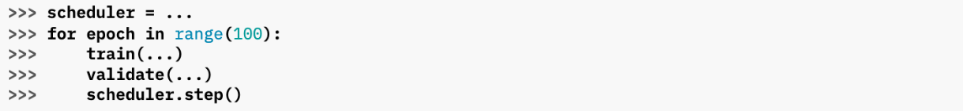

In [16]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', 
                                                 factor=0.5,
                                                 patience=1)

# @@@@@ 3. Training Routine
## 3.1 - Helper function: tracking the training state

In [17]:
def init_train_state(args):
    train_state_dict = {'stop_early'    : False,
                        'early_stopping_step'     : 0,
                        'early_stopping_best_val' : 1e8,
                        'learning_rate' : args.learning_rate,
                        'epoch_index'   : 0,
                        'train_loss'    : [],
                        'train_acc'     : [],
                        'val_loss'      : [],
                        'val_acc'       : [],
                        'test_loss'     : -1,
                        'test_acc'      : -1,
                        'model_filename': args.save_model_name
                       }
    return train_state_dict

def update_train_state(args, model, train_state):
    """
    Handle the training state updates.
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    Args:
        args:  arguments
        model: model to train
        train_state: a dictionary representing the training state values
    
    Returns:
        a new train_state
    """

    # Save the first model
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss increased (not a better model)
        if loss_t >= train_state['early_stopping_best_val']:
            # Update early_stopping_step
            train_state['early_stopping_step'] += 1
        # If loss decreased
        else:
            # Save the best model and update the early_stopping_best_val
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        # In the main training loop, if train_state['stop_early']: break
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [18]:
train_state = init_train_state(args)
train_state

{'stop_early': False,
 'early_stopping_step': 0,
 'early_stopping_best_val': 100000000.0,
 'learning_rate': 0.0001,
 'epoch_index': 0,
 'train_loss': [],
 'train_acc': [],
 'val_loss': [],
 'val_acc': [],
 'test_loss': -1,
 'test_acc': -1,
 'model_filename': 'frankenstein_model.pth'}

{'stop_early': False,
 'early_stopping_step': 0,
 'early_stopping_best_val': 100000000.0,
 'learning_rate': 0.0001,
 'epoch_index': 0,
 'train_loss': [],
 'train_acc': [],
 'val_loss': [],
 'val_acc': [],
 'test_loss': -1,
 'test_acc': -1,
 'model_filename': 'frankenstein_model.pth'}

## 3.2 - Helper function: compute accurary rate

In [19]:
def compute_accuracy(y_pred, y_target, device):
    y_target = y_target.to(device)

    ##### tensor.max(dim=1): the results include two output tensors (max, max_indices)
    _, y_pred_indices = y_pred.to(device).max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [20]:
##### An example - using classifier with initialized (random) parameters
one_batch = next(iter(dataloader))
classifier(one_batch['x_data']).max(dim=1)

torch.return_types.max(
values=tensor([5.5416, 4.9374, 6.0903, 6.2450, 7.2712, 5.0169, 5.4844, 5.8065, 5.1286,
        7.9282, 6.9679, 4.0661, 4.8726, 5.9157, 7.1115, 5.9348, 6.0846, 5.4740,
        6.8991, 7.4032, 5.6459, 6.8911, 6.0887, 4.7703, 6.3371, 7.3463, 5.2765,
        6.4311, 6.7633, 6.5830, 4.7401, 6.5930, 6.1777, 6.0005, 7.6779, 4.1243,
        6.1855, 6.4102, 5.7812, 6.0830, 6.2245, 6.3048, 5.9422, 5.6697, 4.4839,
        6.2726, 5.7615, 5.2116, 5.1176, 7.4406, 5.5918, 5.2272, 4.0307, 7.5915,
        7.6387, 6.4545, 5.7793, 7.2953, 3.3463, 6.8343, 5.4877, 6.1931, 4.6494,
        4.8285, 4.9284, 4.7216, 6.7059, 7.8499, 4.6294, 6.4781, 9.0833, 5.8672,
        3.4117, 3.5425, 5.7063, 7.6229, 5.1692, 8.6998, 7.5741, 7.6618, 6.8277,
        6.1996, 5.8608, 5.8656, 4.6495, 5.4362, 6.7881, 6.6461, 5.9434, 6.6792,
        6.8879, 7.9502, 6.0066, 4.5581, 5.4497, 5.8163, 5.3773, 5.3255, 5.7752,
        6.8285, 4.3371, 5.4577, 4.5280, 5.2168, 6.3023, 3.7984, 7.4381, 6.2610,
        4

torch.return_types.max(
values=tensor([5.5416, 4.9374, 6.0903, 6.2450, 7.2712, 5.0169, 5.4844, 5.8065, 5.1286,
        7.9282, 6.9679, 4.0661, 4.8726, 5.9157, 7.1115, 5.9348, 6.0846, 5.4740,
        6.8991, 7.4032, 5.6459, 6.8911, 6.0887, 4.7703, 6.3371, 7.3463, 5.2765,
        6.4311, 6.7633, 6.5830, 4.7401, 6.5930, 6.1777, 6.0005, 7.6779, 4.1243,
        6.1855, 6.4102, 5.7812, 6.0830, 6.2245, 6.3048, 5.9422, 5.6697, 4.4839,
        6.2726, 5.7615, 5.2116, 5.1176, 7.4406, 5.5918, 5.2272, 4.0307, 7.5915,
        7.6387, 6.4545, 5.7793, 7.2953, 3.3463, 6.8343, 5.4877, 6.1931, 4.6494,
        4.8285, 4.9284, 4.7216, 6.7059, 7.8499, 4.6294, 6.4781, 9.0833, 5.8672,
        3.4117, 3.5425, 5.7063, 7.6229, 5.1692, 8.6998, 7.5741, 7.6618, 6.8277,
        6.1996, 5.8608, 5.8656, 4.6495, 5.4362, 6.7881, 6.6461, 5.9434, 6.6792,
        6.8879, 7.9502, 6.0066, 4.5581, 5.4497, 5.8163, 5.3773, 5.3255, 5.7752,
        6.8285, 4.3371, 5.4577, 4.5280, 5.2168, 6.3023, 3.7984, 7.4381, 6.2610,
        4

In [21]:
outputs = classifier(one_batch['x_data'])
_, pred = outputs.max(dim=1)  
targets = one_batch['y_target']
print('targets:', targets)
print('-'*80)
print('pred:',pred)
print('-'*80)
print('accurary rate:',compute_accuracy(outputs,targets,device='cpu'))

targets: tensor([1533,   88,   15, 1316,  568,   28,    4,  239,   50,   49,   60,  255,
          19,  104,   37,  829,   33,    4,   48,    2,  189,   28,   19, 2239,
         620,   48,   28, 4213, 4327,    2,  362,  138,   48,   19, 1397,   82,
           2,  620,   49,   82,  104, 2013,  542,  196,   44, 2925,    4,  766,
           4, 1790, 1540,   48,   19, 1689,    4,   33,  140,    2,   44,   60,
         211,   82,    2,   68,   88,  521, 1713,  136,  319, 2175, 1022,   48,
          44,   44,   49,   27,   15,  715,    2,   49, 3792, 4032,  321, 3412,
          88, 1776,    2, 3228, 1307, 1229, 2478,   50,    4,   72,  891, 5890,
           4,  103,   92,    2,    4,  290,   19,   30, 2217,   44, 2726,   77,
          23, 5158,   15,  396,   15, 3190,   19,  875,    2,   50,    2, 1882,
        3883,   33,   39,   15, 2529,  395, 1466,   33])
--------------------------------------------------------------------------------
pred: tensor([ 524, 2839, 5581, 4235, 1404, 5768, 340

## 3.3 - Training loop
### - The training loop updates the model parameters so that it improves over time.
### - The training loop is composed of two loops: an inner loop over batches in the dataset, and an outer loop, which repeats the inner loop a number of times.
### - The inner loop (batch), losses are computed for each batch, and the optimizer is used to update the model parameters.

In [22]:
def print_train_state(train_state):
    print('Train Loss:',round(train_state['train_loss'][-1],5))
    print('Train Accuracy:',round(train_state['train_acc'][-1],5))
    print('Valid Loss:',round(train_state['val_loss'][-1],5))
    print('Valid Accuracy:',round(train_state['val_acc'][-1],5))
    print('early_stopping_best_val:',round(train_state['early_stopping_best_val'],5))
    print('early_stopping_step:',train_state['early_stopping_step'])
    print('stop_early:',train_state['stop_early'])

In [23]:
if args.get_model == 'TRAIN':
    ##### Get an initialized train_state
    train_state = init_train_state(args)
    
    for epoch_index in range(args.num_epochs):
        print('-'*60)
        print(f'Epoch {epoch_index}...')
        train_state['epoch_index'] = epoch_index

        ##################################################
        #####     Iterate over training dataset      #####
        ##################################################
        print('Training Iteration...')

        ##### Create a batch_generator using training data
        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)

        ##### running_loss and running_acc are equivalent to the moving averages of loss and accuracy.
        ##### when the loop ends, a moving average is just an average. 
        ##### In each epoch loop, they are reset to zero before the batch loop.
        running_loss = 0.0
        running_acc  = 0.0

        ##### Indicate that the model is in “training mode” 
        # makes the model parameters mutable 
        # and enables regularization mechanisms like dropout
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:
            # --------------------------------------
            ##### STEP 1. zero the gradients
            # Inside each batch iteration, the optimizer’s gradients are first reset
            # Calling backward (step 4 below) will ACCUMULATE gradients, so if the backward()
            # is called earlier, the new gradient is accumulated on top of the one computed 
            # in previous iterations, which leads to an incorrect value for the gradient.
            # Therefore, use this zero_ method to reset the gradients.
            optimizer.zero_grad()

            ##### STEP 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'])

            ##### STEP 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            # update the moving average of loss, batch by batch
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            ##### STEP 4. use loss to produce gradients (gradients are propagated to each parameter)
            # Calling backward() and the gradients at each leaf is ACCUMULATED, not stored.
            # Note that the loss is the loss in train split. There is no valid_loss.backward()
            # because we don't want to train the model on the validation data. 
            loss.backward()

            ##### STEP 5. use optimizer to update parameters
            # the optimizer uses the propagated gradients to perform parameter updates
            # The value of classifier.parameters(), i.e., params is automatically updated in this step. 
            # In specific, the optimizer looks into params.grad and updates params, by substracting 
            # learning_rate * grad from it. 
            optimizer.step()

            ##### Tracking the accuracy
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, 
                                     batch_dict['y_target'],
                                     args.device)
            # update the moving average of acc, batch by batch
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        ##### After this inner loop (training) ends
        # Append the running_loss and running_acc to train_state
        # (the average of loss and acc in all the batches in the current epoch)
        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        ##################################################
        #####     Iterate over validation dataset    #####
        ##################################################
        print('Validation Iteration...')

        ##### Create a batch_generator using validation data
        dataset.set_split('val')    
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        ##### Create new running loss, and running accuracy
        running_loss = 0.0
        running_acc  = 0.0

        ##### Indicate that the model is in “evaluation mode”
        # makes the model parameters immutable 
        # disables dropout
        # disables computation of the loss and propagation of gradients back to the parameters
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            ##### compute the output
            y_pred = classifier(x_in=batch_dict['x_data'])

            ##### STEP 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            ##### compute the accuracy
            acc_t = compute_accuracy(y_pred, 
                                     batch_dict['y_target'],
                                     args.device)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        ##### After this inner loop (validation) ends
        # Append the running_loss and running_acc to train_state
        # (the average of loss and acc in all the batches in the current epoch)
        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        ##### Update the status of Early Stopping and Model Checkpoint
        # Input: the current classifier and current train_state (end of the current epoch loop)
        # Update three items in train_state
        # 1."early_stopping_step" +=1 or reset to 0 (comparing val_loss and early_stopping_best_val)
        # 2."early_stopping_best_val" update to the current val_loss if it is the best model
        # 3."stop_early" if early_stopping_step reaches early_stopping_criteria. If True, break all loops below. 
        # Save a new model if the current model has early_stopping_best_val
        train_state = update_train_state(args = args, model = classifier,
                                         train_state = train_state)
        
        scheduler.step(train_state['val_loss'][-1])
        print('Current lr:', optimizer.param_groups[0]['lr'])

        print_train_state(train_state)

        if train_state['stop_early']:
            break

elif args.get_model == 'LOAD':
    classifier.load_state_dict(torch.load(train_state['model_filename']))
    classifier = classifier.to(args.device)

------------------------------------------------------------
Epoch 0...
Training Iteration...
------------------------------------------------------------
Epoch 0...
Training Iteration...
Validation Iteration...
Validation Iteration...
Current lr: 0.0001
Train Loss: 8.81078
Train Accuracy: 2.13741
Valid Loss: 8.02944
Valid Accuracy: 5.51471
early_stopping_best_val: 100000000.0
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 1...
Training Iteration...
Current lr: 0.0001
Train Loss: 8.81078
Train Accuracy: 2.13741
Valid Loss: 8.02944
Valid Accuracy: 5.51471
early_stopping_best_val: 100000000.0
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 1...
Training Iteration...
Validation Iteration...
Validation Iteration...
Current lr: 0.0001
Train Loss: 7.65211
Train Accuracy: 8.11019
Valid Loss: 7.46838
Valid Accuracy: 8.86765
early_stopping_best_val: 7.46838
early_stopping_ste

Current lr: 0.0001
Train Loss: 5.72494
Train Accuracy: 14.461
Valid Loss: 6.57488
Valid Accuracy: 13.79412
early_stopping_best_val: 6.57488
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 14...
Training Iteration...
Validation Iteration...
Validation Iteration...
Current lr: 0.0001
Train Loss: 5.67707
Train Accuracy: 14.75869
Valid Loss: 6.53732
Valid Accuracy: 14.07353
early_stopping_best_val: 6.53732
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 15...
Training Iteration...
Current lr: 0.0001
Train Loss: 5.67707
Train Accuracy: 14.75869
Valid Loss: 6.53732
Valid Accuracy: 14.07353
early_stopping_best_val: 6.53732
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 15...
Training Iteration...
Validation Iteration...
Validation Iteration...
Current lr: 0.0001
Train Loss: 5.62209
Train Accuracy: 14.75554
Valid Lo

Current lr: 0.0001
Train Loss: 5.21025
Train Accuracy: 15.77148
Valid Loss: 6.44008
Valid Accuracy: 14.80147
early_stopping_best_val: 6.44008
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 28...
Training Iteration...
Validation Iteration...
Validation Iteration...
Current lr: 0.0001
Train Loss: 5.17941
Train Accuracy: 15.83449
Valid Loss: 6.4405
Valid Accuracy: 14.68382
early_stopping_best_val: 6.44008
early_stopping_step: 1
stop_early: False
------------------------------------------------------------
Epoch 29...
Training Iteration...
Current lr: 0.0001
Train Loss: 5.17941
Train Accuracy: 15.83449
Valid Loss: 6.4405
Valid Accuracy: 14.68382
early_stopping_best_val: 6.44008
early_stopping_step: 1
stop_early: False
------------------------------------------------------------
Epoch 29...
Training Iteration...
Validation Iteration...
Validation Iteration...
Current lr: 5e-05
Train Loss: 5.16
Train Accuracy: 15.98412
Valid Loss: 

# @@@@@ 4. Evaluation
## 4.1 - Evaluation on Test Data
### There are a few reasons why the result is not super high. 
### 1) In this illustrative example, there are many properties of the original implementation that have been left out because they add complexity unnecessary for learning (but necessary for optimal performance). 
### 2) The dataset we are using is minuscule. In contrast, state-of-the-art embeddings are typically trained on datasets with terabytes of text.

In [24]:
classifier = CBOWClassifier(vocabulary_size = len(vectorizer.cbow_vocab), 
                            embedding_size  = args.embedding_size, 
                            padding_idx     = 0)

filename   = args.output_path+'/frankenstein_model.pth'
classifier.load_state_dict(torch.load(filename))
classifier = classifier.to(args.device)

loss_func = nn.CrossEntropyLoss()

##### Create a batch_generator using test data
# The test set should be run as little as possible
# Avoid make a new model decision based on the evaluation on test data
# Otherwise the model might be biased toward the test data, and the test data will 
# become meaningless as an measure of truly held-out data.
dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size = args.batch_size, 
                                   device     = args.device)

##### Create new running loss, and running accuracy
running_loss = 0.0
running_acc  = 0.0

##### Indicate that the model is in “evaluation mode”
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(batch_dict['x_data'])

    # compute the loss
    loss   = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'],args.device)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

print("Test loss: {:.5f}".format(running_loss))
print("Test Accuracy: {:.5f}".format(running_acc))

Test loss: 7.64303
Test Accuracy: 13.99265
Test loss: 7.64303
Test Accuracy: 13.99265


## 4.2 Generation a prediction for a given context (predicting the fourth word in a sentence containing seven words)

In [25]:
classifier = CBOWClassifier(vocabulary_size = len(vectorizer.cbow_vocab), 
                            embedding_size  = args.embedding_size, 
                            padding_idx     = 0)

filename   = args.output_path+'/frankenstein_model.pth'
classifier.load_state_dict(torch.load(filename))
classifier = classifier.to(args.device)
vectorizer = dataset.get_vectorizer()

In [26]:
sentences = [
    'the sun shines in the blue sky',
    'rivers flow quietly through green valleys',
    'children play and laugh in the park'
]

### Neural network models expect input tensors to have specific shapes. Typically, the input tensor to this model is a batch of data, containing multiple samples. When pass a single sample to the model, one needs to first wrap it in a batch of size 1.
### Two approaches:
### 1) The [.unsqueeze(dim=0) ](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html)method adds a dimension at the specified dimension, effectively converting the original tensor into a batch of size 1. In this case, we're converting the tensor of a single sample into a batch tensor containing that single sample.
### 2) The [.view(1, -1)](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html) method reshape the original tensor into a batch tensor of size 1, where the first dimension is 1, and the other dimensions are automatically calculated based on the total number of elements in the original tensor. This allows you to pass a single sample to the model for prediction.

In [28]:
for sentence in sentences:
    words   = sentence.split()
    target  = words[3]
    del words[3]
    context = ' '.join(words)
    print("Context:", context)
    print("Target:", target)
    print("Output:")
    ### Because the classifier includes a dropout layer with a p=0.3),
    ### the output contains random variations.
    output = classifier(torch.tensor(vectorizer.vectorize(context)).unsqueeze(dim=0))
    ### Alternatively
    # output = classifier(torch.tensor(vectorizer.vectorize(context)).view(1, -1))
    print(output)
    
    n_top = 10
    top_values, top_indices = torch.topk(output, k=n_top)
    top_indices = top_indices.squeeze(0).numpy()
    
    top_pred_words = []
    for i in top_indices:
        top_pred_words += [dataset._vectorizer.cbow_vocab.lookup_index(i)]
    print(f"Top {n_top} predicted words:")
    print(top_pred_words)
    print("-"*100)

Context: the sun shines the blue sky
Target: in
Output:
tensor([[-15.0621, -15.0051,   3.5125,  ...,  -6.7149,  -7.9451, -15.0598]],
       grad_fn=<AddmmBackward0>)
Top 10 predicted words:
['of', ',', 'and', 'morning', 'which', 'as', 'in', 'from', 'to', 'i']
----------------------------------------------------------------------------------------------------
Context: rivers flow quietly green valleys
Target: through
Output:
tensor([[-7.2917, -7.2334,  2.5704,  ..., -2.8515, -2.6058, -7.2897]],
       grad_fn=<AddmmBackward0>)
Top 10 predicted words:
['the', ',', 'gave', 'and', 'prolong', 'vengeance', 'to', 'would', 'enabled', 'presents']
----------------------------------------------------------------------------------------------------
Context: children play and in the park
Target: laugh
Output:
tensor([[-13.8679, -13.8116,   3.4723,  ...,  -5.7451,  -4.6007, -13.8668]],
       grad_fn=<AddmmBackward0>)
Top 10 predicted words:
['of', ',', 'to', 'in', 'most', 'the', 'a', 'and', 'had', 

## 4.3 Trained Embeddings
### The analysis below find the nearest n words in the vocabulary (dataset._vectorizer.cbow_vocab) to the given word, where the distance between words is based on the [2-norm](https://pytorch.org/docs/stable/generated/torch.dist.html).

### Like mentioned above, this is a simplified model and the training data is very limited. Therefore, the embedding obtained in this classifier is not a very good vector representation. A similar analysis ([see ipynb here](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Frankenstein/pretrained_embeddings_GloVe.ipynb)) was conducted using pre-trained embeddings (GloVe by Stanford).

In [29]:
classifier = CBOWClassifier(vocabulary_size = len(vectorizer.cbow_vocab), 
                            embedding_size  = args.embedding_size, 
                            padding_idx     = 0)

filename   = args.output_path+'/frankenstein_model.pth'
classifier.load_state_dict(torch.load(filename))
classifier = classifier.to(args.device)
embeddings = classifier.embedding.weight.data

vectorizer = dataset.get_vectorizer()
word_to_idx = vectorizer.cbow_vocab._token_to_idx

In [30]:
def get_closest(input_word, word_to_idx, embeddings, n=5):
    """
    Get the n closest
    words to your word.
    """

    # Calculate distances (2-norm) to all other words
    # 
    word_embedding = embeddings[word_to_idx[input_word.lower()]]
    distances = []
    for word, index in word_to_idx.items():
        if word == "<MASK>" or word == input_word:
            continue
        distances.append((word, torch.dist(word_embedding, embeddings[index])))
    
    # Sorting the list using the sorted() function with a lambda function which
    # specifies through the key parameter. The lambda function returns the second 
    # element of each tuple (2-norm value) as the sorting criterion.
    results = sorted(distances, key=lambda x: x[1])[0:n+1]
    return results

In [31]:
get_closest('monster', word_to_idx, embeddings, n=5)

[('picturesque', tensor(6.6047)),
 ('sentences', tensor(6.6982)),
 ('loathsome', tensor(6.8005)),
 ('walking', tensor(6.9838)),
 ('fatal', tensor(7.0117)),
 ('consoled', tensor(7.1081))]

[('picturesque', tensor(6.6047)),
 ('sentences', tensor(6.6982)),
 ('loathsome', tensor(6.8005)),
 ('walking', tensor(6.9838)),
 ('fatal', tensor(7.0117)),
 ('consoled', tensor(7.1081))]

In [32]:
get_closest('frankenstein', word_to_idx, embeddings, n=5)

[('imaginations', tensor(5.7929)),
 ('moonshine', tensor(6.1915)),
 ('wreck', tensor(6.2560)),
 ('caresses', tensor(6.3671)),
 ('conjectured', tensor(6.3714)),
 ('earth', tensor(6.4475))]

[('imaginations', tensor(5.7929)),
 ('moonshine', tensor(6.1915)),
 ('wreck', tensor(6.2560)),
 ('caresses', tensor(6.3671)),
 ('conjectured', tensor(6.3714)),
 ('earth', tensor(6.4475))]

In [33]:
get_closest('happy', word_to_idx, embeddings, n=5)

[('removed', tensor(6.1792)),
 ('wail', tensor(6.2022)),
 ('returned', tensor(6.2720)),
 ('firmest', tensor(6.4226)),
 ('latter', tensor(6.4275)),
 ('fortifications', tensor(6.4317))]

[('removed', tensor(6.1792)),
 ('wail', tensor(6.2022)),
 ('returned', tensor(6.2720)),
 ('firmest', tensor(6.4226)),
 ('latter', tensor(6.4275)),
 ('fortifications', tensor(6.4317))]